In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Model
from keras import optimizers
import numpy as np
import shap
import keras.backend as K
import json
import split_folders
import boto3

Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# split_folders.ratio('data/', output="output", seed=1337, ratio=(.8, .2))

In [ ]:
def download_file_with_resource(bucket_name, key, local_path):
    s3 = boto3.resource('s3')
    s3.Bucket(bucket_name).download_file(key, local_path)
    print('Downloaded File with boto3 resource')

bucket_name = 'dog-breed-identification'
key = '*' 
local_path = '<e.g. ./log.txt>'

download_file_with_resource(bucket_name, key, local_path)

In [2]:
target_size = 300

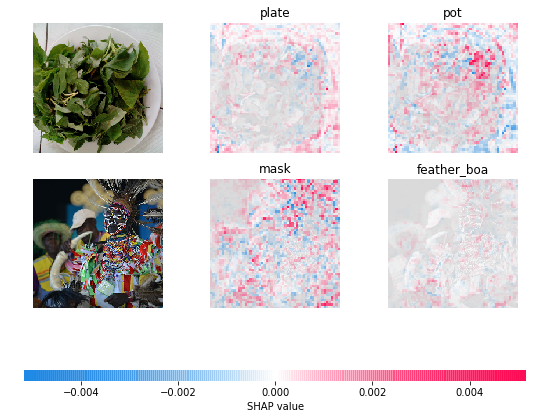

In [4]:
# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True) ## CHANGE INCLUDE TOP TO FALSE
X,y = shap.datasets.imagenet50()
to_explain = X[[6,7]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer((model.layers[7].input, model.layers[-1].output), map2layer(preprocess_input(X.copy()), 7))
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

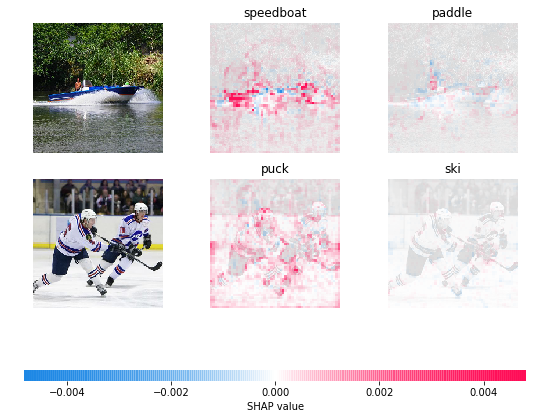

In [5]:
shap.image_plot(shap_values, to_explain, index_names)

In [5]:
img_width = target_size
img_height = target_size
batch_size =16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling (we do not want to modify the testing data)
test_datagen = ImageDataGenerator(rescale=1. / 255)


# The generator object. 
train_generator = train_datagen.flow_from_directory(
    'output/train',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'output/val',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 3757 images belonging to 17 classes.
Found 948 images belonging to 17 classes.


In [6]:
def add_new_last_layer(base_model, nb_classes=17):
    """Add last layer to the convnet
    Args:
    base_model: keras model excluding top
    nb_classes: # of classes
    Returns:
    new keras model with last layer
    """
    # Get the output shape of the models last layer
    x = base_model.output
    # Convert final MxNxC tensor output into a 1xC tensor where C is the # of channels.
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x) 
    x = Dropout(.5)(x)
    predictions = Dense(nb_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [7]:
# This will freeze the weights on all the layers except for our new dense layer
def setup_to_transfer_learn(model, base_model):
  """Freeze all layers and compile the model"""
  for layer in base_model.layers:
    layer.trainable = False
  model.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),    
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

In [8]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(target_size,target_size,3))

tran_model = add_new_last_layer(base_model)
setup_to_transfer_learn(tran_model,base_model)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
nb_epoch = 8

tran_model.fit_generator(
    train_generator,
    epochs=nb_epoch,
    steps_per_epoch=100,
    validation_data=validation_generator,
    validation_steps=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/8
 17/100 [====>.........................] - ETA: 50s - loss: 2.9678 - acc: 0.0735

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


 51/100 [==============>...............] - ETA: 27s - loss: 2.9755 - acc: 0.0588

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6 bytes but only got 5. Skipping tag 42036
  " Skipping tag %s" % (size, len(data), tag))


100/100 [==============================] - 59s 589ms/step - loss: 2.9572 - acc: 0.0625 - val_loss: 2.8355 - val_acc: 0.0563
Epoch 2/8
100/100 [==============================] - 55s 549ms/step - loss: 2.9107 - acc: 0.0769 - val_loss: 2.8303 - val_acc: 0.0813
Epoch 3/8
  2/100 [..............................] - ETA: 28s - loss: 2.8174 - acc: 0.1250

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


100/100 [==============================] - 55s 546ms/step - loss: 2.8889 - acc: 0.0770 - val_loss: 2.8282 - val_acc: 0.0625
Epoch 4/8
100/100 [==============================] - 56s 555ms/step - loss: 2.9150 - acc: 0.0531 - val_loss: 2.8189 - val_acc: 0.0688
Epoch 5/8
100/100 [==============================] - 55s 552ms/step - loss: 2.8785 - acc: 0.0820 - val_loss: 2.8140 - val_acc: 0.1125
Epoch 6/8
100/100 [==============================] - 55s 550ms/step - loss: 2.8840 - acc: 0.0631 - val_loss: 2.8138 - val_acc: 0.0743
Epoch 7/8
100/100 [==============================] - 55s 555ms/step - loss: 2.8747 - acc: 0.0775 - val_loss: 2.8139 - val_acc: 0.0813
Epoch 8/8
100/100 [==============================] - 56s 562ms/step - loss: 2.8709 - acc: 0.0645 - val_loss: 2.7942 - val_acc: 0.1375


In [10]:
img = load_img('output/val/basset_hound/220px-Bvdb-bassethound1.jpg',target_size=(target_size,target_size) )
img = img_to_array(img)
img = img.reshape((1,) + img.shape)
img.shape

(1, 300, 300, 3)

In [11]:
pred = tran_model.predict(img)
pred

array([[5.8419997e-01, 2.2758858e-04, 5.7769120e-03, 3.5274462e-03,
        5.6137361e-02, 3.2833836e-03, 7.9529835e-03, 3.5974693e-02,
        1.6126280e-01, 2.8025876e-03, 1.3066061e-01, 4.9220491e-03,
        2.2887511e-06, 1.0330916e-03, 1.7709004e-04, 1.4551327e-04,
        1.9136089e-03]], dtype=float32)

In [12]:
np.round(pred, decimals=3)

array([[0.584, 0.   , 0.006, 0.004, 0.056, 0.003, 0.008, 0.036, 0.161,
        0.003, 0.131, 0.005, 0.   , 0.001, 0.   , 0.   , 0.002]],
      dtype=float32)

In [14]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [17]:
# load pre-trained model and choose two images to explain
# model = VGG16(weights='imagenet', include_top=True) ## CHANGE INCLUDE TOP TO FALSE
model = tran_model
# X,y = shap.datasets.imagenet50()
img = load_img('output/val/basset_hound/220px-Bvdb-bassethound1.jpg',target_size=(224,224) )
img = img_to_array(img)
img = img.reshape((1,) + img.shape)
to_explain = img
X = img

# # load the ImageNet class names
# url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
# fname = shap.datasets.cache(url)
# with open(fname) as f:
#     class_names = json.load(f)
class_names = labels

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

e = shap.GradientExplainer((model.layers[7].input, model.layers[-1].output), map2layer(preprocess_input(X.copy()), 7))
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

ValueError: Cannot feed value of shape (1, 224, 224, 3) for Tensor 'input_3:0', which has shape '(?, 300, 300, 3)'

In [18]:
K.get_session().run(model.layers[layer].input, feed_dict)

NameError: name 'layer' is not defined